In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

from UniGaussianNets import (
    normal_marginals,
    gen_gauss_weights,
    gen_unif_weights,
    show_weights,
    show_3d_weights,
    Network,
    unzip,
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [2]:
N = 30  # We'll use 30x30 board

# Gaussian weights

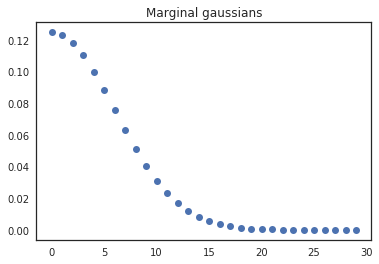

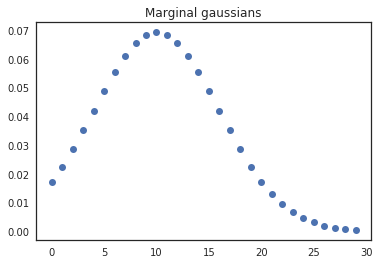

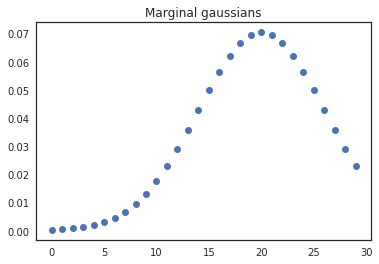

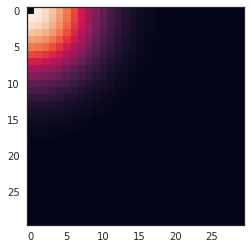

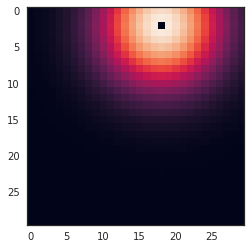

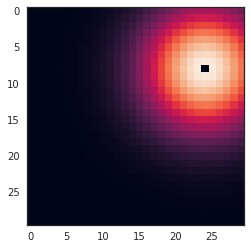

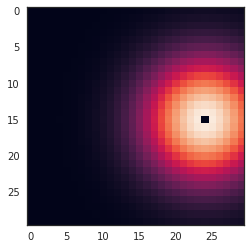

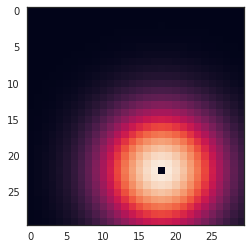

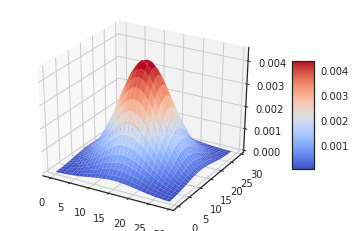

In [3]:
# generate marginal gaussian distribution that will be combined into 2D
# "marginal" is a fancy statistics term, think about it like a projection on on axis
# i.e. 2D gaussian hill -> 1D gaussian slice
marginals = normal_marginals(N, 0.2)
for subset in marginals[::10]:
    plt.plot(subset, "o")
    plt.title("Marginal gaussians")
    plt.show()
# Combine the marginals into the 2D thing, it's just a multiplication
weights = gen_gauss_weights(marginals)
show_weights(weights, N)
show_3d_weights(weights[int(N * (N - 1) / 2)], N)

# Uniform weights

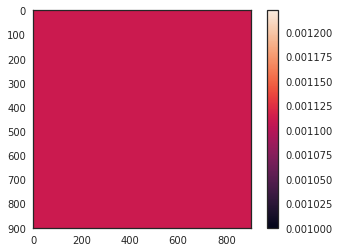

In [4]:
# do I even need to comment this?
weights = gen_unif_weights(N)

plt.imshow(weights)
plt.colorbar()  # nice plot uh?

# Sampling

## Gaussian

In [5]:
node = N * (N - 1) // 2  # pick a node in the center
marginals = normal_marginals(N, 0.2)
weights = gen_gauss_weights(marginals)
num_points = N ** 2
locality = 0.2
nodes = np.arange(N * N)

Test single samples, we should see a noisy gaussian structure

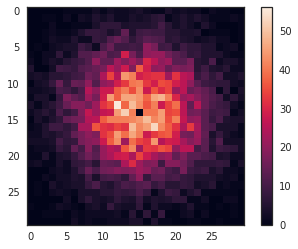

In [6]:
nodes = np.arange(N * N)
samples = [
    np.random.choice(nodes, p=weights[node], replace=False, size=1)[0]
    for _ in range(10000)
]

# How many times each node has been picked?
samples = Counter(samples).most_common()

results = np.zeros((N, N))
for coord, count in samples:
    # turn nodes id into coordinates for plotting
    x, y = coord // N, coord % N
    results[x][y] = count
plt.imshow(results)
plt.colorbar()

Reconstruct the marginals from the samples as a sanity check (and also looks cool)

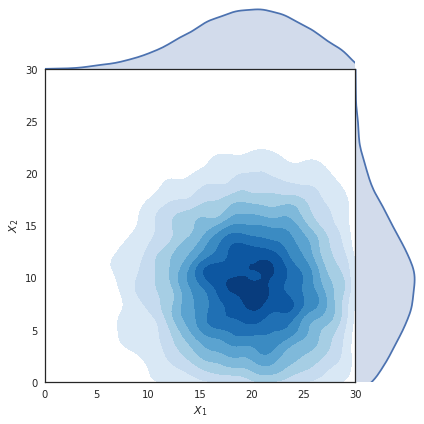

In [12]:
node = N * (N - 1) // 3  # pick a node in the center
to = [
    np.random.choice(nodes, p=weights[node], replace=False, size=1)[0]
    for _ in range(10000)
]
x1, x2 = unzip([(node % N, node // N) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

g = sns.JointGrid(x1, x2, space=0, xlim=(0, N), ylim=(0, N))
g = g.plot_joint(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot, shade=True)

In [13]:
g.savefig("gaussian_sample.png")

Test a node very close to the edge

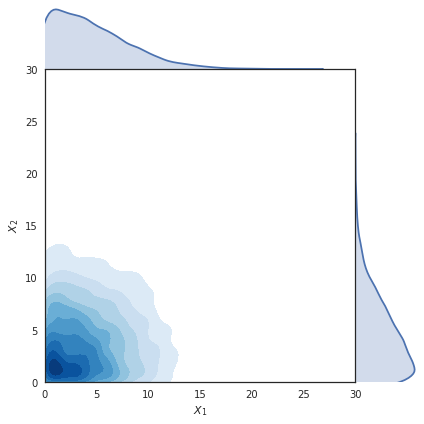

In [8]:
node = 0  # test a node very close to the border
# Reconstruct the marginals from the samples
to = [
    np.random.choice(nodes, p=weights[node], replace=False, size=1)[0]
    for _ in range(10000)
]
x1, x2 = unzip([(node % N, node // N) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

g = sns.JointGrid(x1, x2, space=0, xlim=(0, N), ylim=(0, N))
g = g.plot_joint(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot, shade=True)

Test sampling all the points in one go

In [9]:
node = N * (N - 1) // 2  # pick a node in the center

# draw all possible edges in one go, there are N**2-1 of them
samples = [
    np.random.choice(np.arange(N * N), p=weights[node], replace=False, size=N ** 2 - 1)
    for _ in range(1000)
]

In [10]:
# For each sample check the n-th node
# if everything is working we should see that the closer ones are picked first on average
def check_position(samples, nth):
    nodes = []
    for sample in samples:
        nodes.append(sample[nth])

    nodes = Counter(nodes).most_common()
    results = np.zeros((N, N))
    for coord, count in nodes:
        x, y = coord // N, coord % N
        results[x][y] = count
    plt.imshow(results)
    plt.title("{}-th samples".format(nth))
    plt.show()

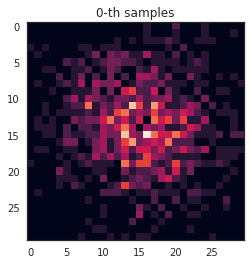

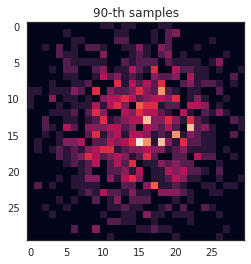

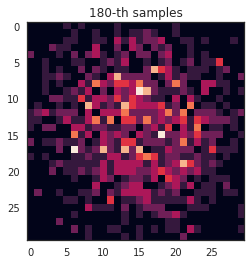

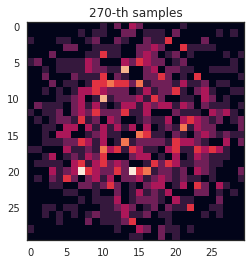

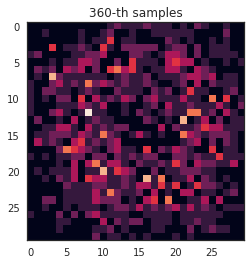

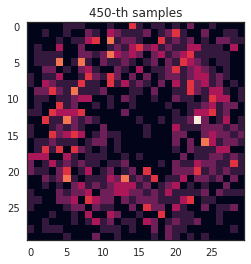

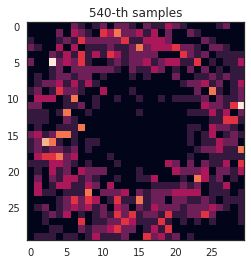

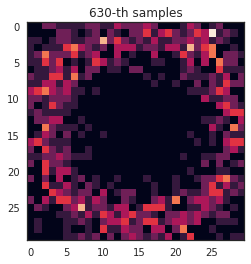

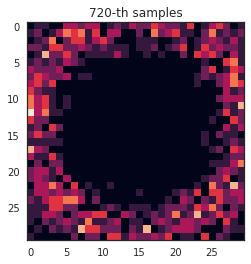

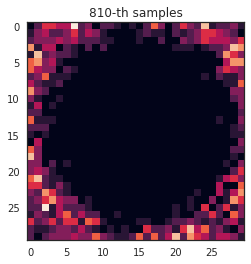

In [11]:
for i in range(0, N ** 2 - 1, N ** 2 // 10):
    check_position(samples, i)

Seems to be working, at first the nodes closer to the center are picked then it runs out of them and it forms that donut shape pattern.

# Network usage with undo/commit

In [12]:
g_opts = {"distr": "gauss", "locality": 0.2}
# g_opts = {"distr": "gauss", "locality": 1}
u_opts = {"distr": "unif"}

In [13]:
net = Network(30, g_opts)

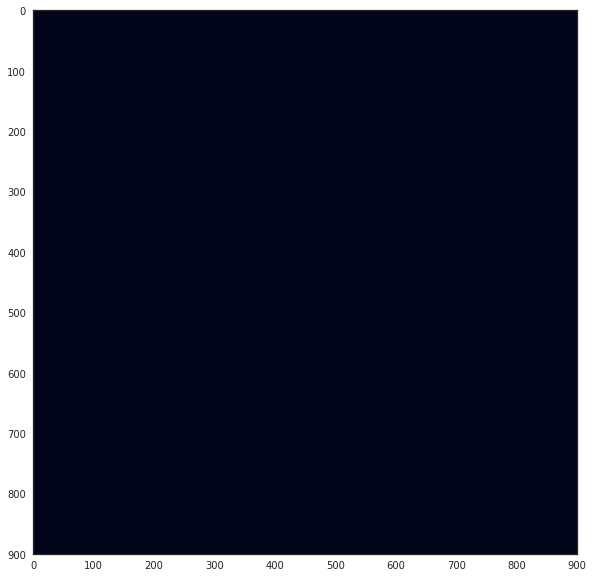

In [14]:
net.show_adj()

In [15]:
node = 13 * 20
added_edges = net.add_edges(node, 100)
added_edges

array([ 80, 129, 258, 139, 443, 136, 532, 230,  45,  44,   9, 206,  48,
        46, 255, 351, 322, 563, 257, 406, 530, 445, 383,  21,  13, 164,
        49, 432, 325, 562, 264, 166, 500, 621, 319, 463, 161, 434, 382,
       287,  79, 169, 198, 375,  50, 471, 195, 138, 144, 376, 200,  22,
       686,  38, 370, 373, 459, 229, 256, 473, 232, 197, 220,  19, 590,
       346, 474, 436, 226, 623, 291, 228, 135, 265,  84, 231, 167, 467,
       585, 430, 344,  87, 259,  26, 107, 261, 196, 617,   6, 168, 458,
       407, 381, 416, 234, 288, 223, 109, 239, 595])

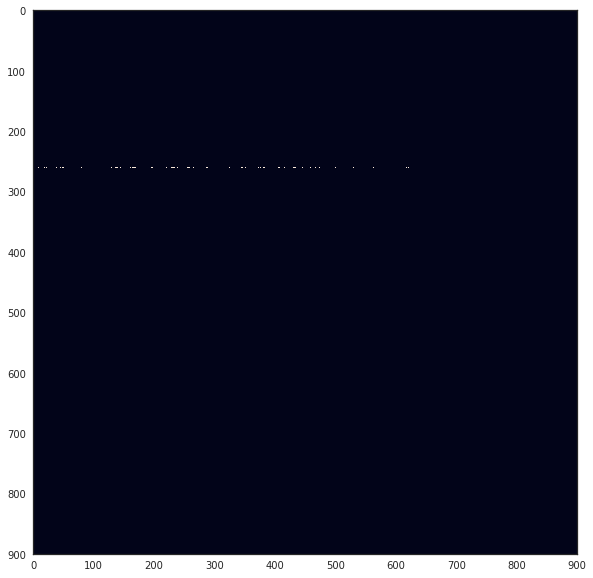

In [16]:
net.show_adj()

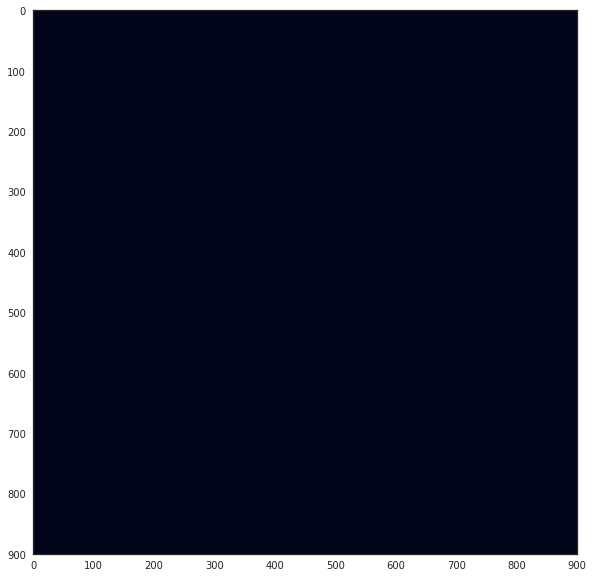

In [17]:
net.undo()
net.show_adj()

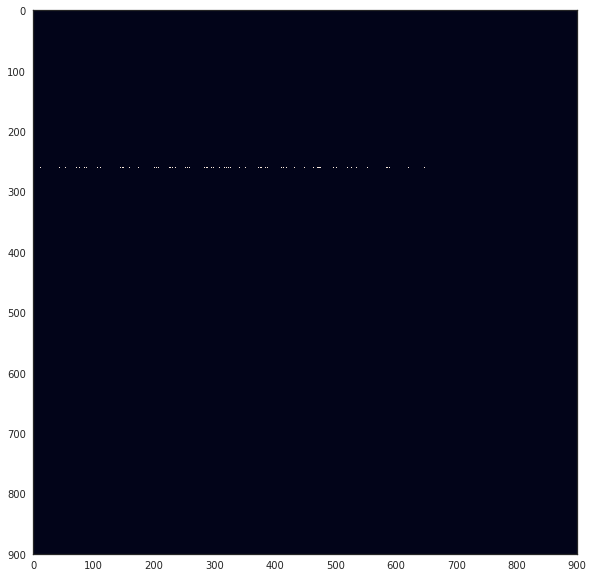

In [18]:
net.add_edges(node, 100)
net.show_adj()

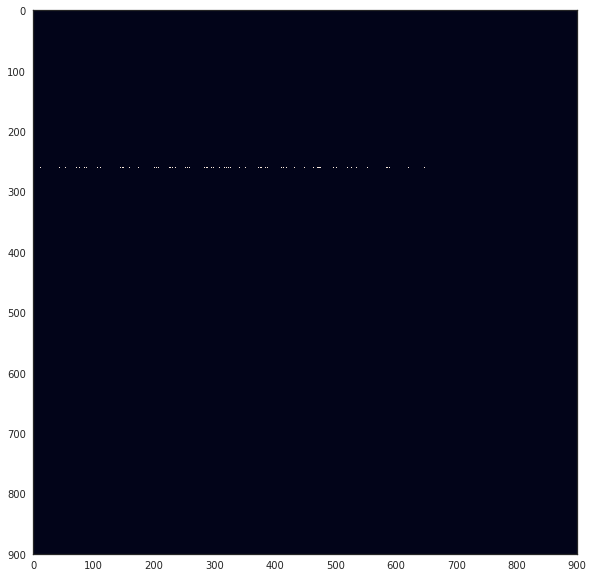

In [19]:
net.commit()
net.show_adj()

In [20]:
net.serialize()

'2019-11-22_162906_distr_gauss_locality_02.edgelist'